### random forest retry

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[

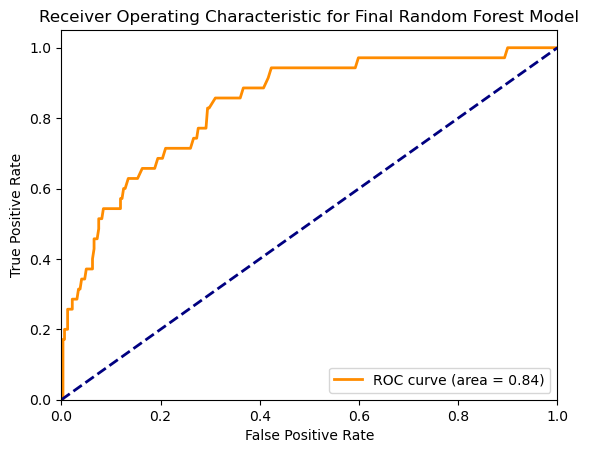

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed)
    return train_data, valid_data

# Preprocess the data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed=42)

X_train = train_data[predictor_names].values
y_train = train_data['outcome'].values
X_valid = valid_data[predictor_names].values
y_valid = valid_data['outcome'].values

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters found
best_rf = grid_search.best_estimator_
print("Best hyperparameters found:", grid_search.best_params_)

# Train the final model with the best hyperparameters
best_rf.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model
y_pred_proba_final = best_rf.predict_proba(X_valid)[:, 1]
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

print(classification_report(y_valid, y_pred_final, zero_division=0))

# Calculate AUC for the final model
auc_final = roc_auc_score(y_valid, y_pred_proba_final)
print(f"Final AUC: {auc_final}")

# Plot ROC curve for the final model
fpr_final, tpr_final, thresholds_final = roc_curve(y_valid, y_pred_proba_final)
plt.figure()
plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'ROC curve (area = {auc_final:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Final Random Forest Model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed)
    return train_data, valid_data

# Preprocess the data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed=42)

X_train = train_data[predictor_names].values
y_train = train_data['outcome'].values
X_valid = valid_data[predictor_names].values
y_valid = valid_data['outcome'].values

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the base models
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Define the stacking model
estimators = [('rf', rf), ('gb', gb)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(random_state=42), cv=5, n_jobs=-1)

# Hyperparameter tuning using GridSearchCV for the stacking model
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20],
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.01, 0.1],
    'final_estimator__n_estimators': [100, 200],
    'final_estimator__learning_rate': [0.01, 0.1]
}

grid_search = GridSearchCV(estimator=stacking_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters found
best_stacking_model = grid_search.best_estimator_
print("Best hyperparameters found:", grid_search.best_params_)

# Train the final model with the best hyperparameters
best_stacking_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model
y_pred_proba_final = best_stacking_model.predict_proba(X_valid)[:, 1]
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

print(classification_report(y_valid, y_pred_final, zero_division=0))

# Calculate AUC for the final model
auc_final = roc_auc_score(y_valid, y_pred_proba_final)
print(f"Final AUC: {auc_final}")

# Plot ROC curve for the final model
fpr_final, tpr_final, thresholds_final = roc_curve(y_valid, y_pred_proba_final)
plt.figure()
plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'ROC curve (area = {auc_final:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Final Stacking Model')
plt.legend(loc="lower right")
plt.show()


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=100, gb__learning_rate=0.01, gb__n_estimators=100, rf__max_depth=10, rf__n_estimators=100; total time=   7.1s
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=100, gb__learning_rate=0.01, gb__n_estimators=100, rf__max_depth=20, rf__n_estimators=100; total time=   7.2s
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=100, gb__learning_rate=0.01, gb__n_estimators=100, rf__max_depth=20, rf__n_estimators=100; total time=   7.2s
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=100, gb__learning_rate=0.01, gb__n_estimators=100, rf__max_depth=10, rf__n_estimators=100; total time=   7.3s
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=100, gb__learning_rate=0.01, gb__n_estimators=100, rf__max_depth=10, rf__n_estimators=100; total time=   7.5s
[CV] END